![alt text](http://drive.google.com/uc?export=view&id=1IFEWet-Aw4DhkkVe1xv_2YYqlvRe9m5_)

# 10.2 Regularized Logistic Regression

This tutorial will guide you through implementing Regularized Logistic Regression in Python, converting the provided R tutorial. We'll cover both building a model from scratch to understand the underlying mathematics and using the efficient `scikit-learn` library (Python's equivalent to R's `glmnet`).

## Overview

Regularized logistic regression is an enhanced version of traditional logistic regression that employs regularization techniques to prevent overfitting and improve model generalization. When dealing with high-dimensional datasets or highly correlated predictors, traditional logistic regression can overfit. Regularization addresses this by adding a penalty term to shrink coefficients.

There are three main types of regularization:
- **L1 Regularization (Lasso)**: Encourages sparsity by setting some coefficients exactly to zero, effectively performing feature selection.
- **L2 Regularization (Ridge)**: Shrinks all coefficients toward zero but keeps all predictors in the model, helping handle multicollinearity.
- **Elastic Net**: Combines L1 and L2 regularization, balancing feature selection and coefficient shrinkage.

The mathematical foundation remains the same as in the R tutorial:
- The **logit link function** models the log-odds: `logit(P) = ln(P/(1-P)) = β₀ + β₁X₁ + ... + βₚXₚ`
- The **log-likelihood** function is: `ℓ(β) = Σ[Yᵢln(Ŷᵢ) + (1-Yᵢ)ln(1-Ŷᵢ)]`
- The **penalized negative log-likelihood** adds a penalty: `Penalized Loss = -ℓ(β) + λ·P(β)`

## Regularized Logistic Model from Scratch

First, let's implement regularized logistic regression from scratch in Python to understand the underlying mechanics.

### Simulated Data

Simulate a dataset with a binary response variable and multiple predictor variables. The response variable is generated using the logistic function with the true coefficients. The predictor matrix X is generated from a standard normal distribution.

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(123)

# Generate synthetic data for binary logistic regression
n = 200  # Number of observations
p = 10   # Number of features
X = np.random.normal(0, 1, (n, p))  # Design matrix (n x p)
beta_true = np.array([3, -2, 1] + [0] * (p-3))  # True coefficients (sparse)
y_prob = 1 / (1 + np.exp(-X @ beta_true))  # Logistic function for probabilities
y = np.random.binomial(1, y_prob, n)  # Binary outcome variable

print(f"Generated {n} samples with {p} features")
print(f"True coefficients: {beta_true}")

Generated 200 samples with 10 features
True coefficients: [ 3 -2  1  0  0  0  0  0  0  0]


### Define log-likelihood and penalty functions

In [2]:
def log_likelihood(X, y, beta):
    """Calculate logistic regression log-likelihood"""
    p = 1 / (1 + np.exp(-X @ beta))  # Predicted probabilities
    # Avoid log(0) by adding small epsilon
    epsilon = 1e-15
    p = np.clip(p, epsilon, 1 - epsilon)
    ll = np.sum(y * np.log(p) + (1 - y) * np.log(1 - p))
    return ll

def l1_penalty(beta):
    """L1 (Lasso) penalty"""
    return np.sum(np.abs(beta))

def l2_penalty(beta):
    """L2 (Ridge) penalty"""
    return np.sum(beta ** 2)

def elastic_net_penalty(beta, alpha):
    """Elastic Net penalty (combination of L1 and L2)"""
    return alpha * l1_penalty(beta) + (1 - alpha) * l2_penalty(beta)

def penalized_negative_log_likelihood(X, y, beta, lambda_, alpha):
    """Calculate penalized negative log-likelihood"""
    ll = log_likelihood(X, y, beta)
    penalty = elastic_net_penalty(beta, alpha)
    return -ll + lambda_ * penalty

### Coordinate Descent Algorithm

In [3]:
def coordinate_descent(X, y, lambda_, alpha, tol=1e-6, max_iter=1000):
    """
    Implement coordinate descent for regularized logistic regression
    """
    n, p = X.shape
    beta = np.zeros(p)
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    for iter_ in range(max_iter):
        beta_old = beta.copy()
        
        for j in range(p):
            # Calculate residual without feature j
            r_j = y - X_scaled @ beta + beta[j] * X_scaled[:, j]
            z_j = np.sum(X_scaled[:, j] ** 2)
            rho_j = np.sum(X_scaled[:, j] * r_j)
            
            # Update beta based on regularization type
            if alpha == 1:  # Lasso
                beta[j] = np.sign(rho_j) * max(abs(rho_j) - lambda_, 0) / z_j
            elif alpha == 0:  # Ridge
                beta[j] = rho_j / (z_j + lambda_)
            else:  # Elastic Net
                beta[j] = (np.sign(rho_j) * 
                          max(abs(rho_j) - lambda_ * alpha, 0) / 
                          (z_j + lambda_ * (1 - alpha)))
        
        # Check for convergence
        if np.sum(np.abs(beta - beta_old)) < tol:
            print(f"Converged after {iter_ + 1} iterations")
            break
    
    return beta

### Cross-validation for hyperparameter tuning

In [4]:
def cross_validate(X, y, lambdas, alphas, k_folds=5):
    """
    Perform k-fold cross-validation to find optimal hyperparameters
    """
    n = X.shape[0]
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    
    best_lambda = None
    best_alpha = None
    best_accuracy = -np.inf
    
    # Loop over all combinations of lambda and alpha
    for lambda_ in lambdas:
        for alpha in alphas:
            accuracy_scores = []
            
            for train_idx, val_idx in kf.split(X):
                X_train, X_val = X[train_idx], X[val_idx]
                y_train, y_val = y[train_idx], y[val_idx]
                
                # Fit model with current lambda and alpha
                beta = coordinate_descent(X_train, y_train, lambda_, alpha)
                
                # Make predictions
                p_val = 1 / (1 + np.exp(-X_val @ beta))
                y_pred = (p_val > 0.5).astype(int)
                
                # Calculate accuracy
                accuracy = np.mean(y_pred == y_val)
                accuracy_scores.append(accuracy)
            
            avg_accuracy = np.mean(accuracy_scores)
            
            # Track best parameters
            if avg_accuracy > best_accuracy:
                best_accuracy = avg_accuracy
                best_lambda = lambda_
                best_alpha = alpha
    
    return {
        'lambda': best_lambda, 
        'alpha': best_alpha, 
        'accuracy': best_accuracy
    }

### Run Regularized Logistic Regression with Cross-Validation

Run the regularized logistic regression model with cross-validation to select the best hyperparameters (alpha and lambda). The model is trained on the standardized predictor matrix X_scaled and the response variable y. The grid of hyperparameters includes five values for alpha (0 to 1) and ten values for lambda ($10^{-2}$ to $10^2$). The best alpha and lambda values are selected based on the lowest average cross-validation loss.

In [5]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define hyperparameter grid
lambdas = np.arange(0.001, 1.01, 0.01)  # Regularization strength
alphas = [0, 0.5, 1]  # Ridge (0), Elastic Net (0.5), Lasso (1)

# Perform cross-validation
cv_results = cross_validate(X_scaled, y, lambdas, alphas)
print(f"Best lambda: {cv_results['lambda']}")
print(f"Best alpha: {cv_results['alpha']}")
print(f"Best accuracy: {cv_results['accuracy']:.4f}")

Converged after 8 iterations
Converged after 8 iterations
Converged after 7 iterations
Converged after 7 iterations
Converged after 9 iterations
Converged after 8 iterations
Converged after 8 iterations
Converged after 7 iterations
Converged after 7 iterations
Converged after 9 iterations
Converged after 8 iterations
Converged after 8 iterations
Converged after 7 iterations
Converged after 7 iterations
Converged after 9 iterations
Converged after 8 iterations
Converged after 8 iterations
Converged after 7 iterations
Converged after 7 iterations
Converged after 9 iterations
Converged after 8 iterations
Converged after 8 iterations
Converged after 7 iterations
Converged after 7 iterations
Converged after 9 iterations
Converged after 8 iterations
Converged after 8 iterations
Converged after 7 iterations
Converged after 7 iterations
Converged after 9 iterations
Converged after 8 iterations
Converged after 8 iterations
Converged after 7 iterations
Converged after 7 iterations
Converged afte

### Final Model Fit with best alpha and lambda

Final model is fitted with the best alpha and lambda values selected from cross-validation. The model coefficients are displayed to show the impact of each predictor on the outcome.

In [6]:
# Fit final model with best parameters
final_beta = coordinate_descent(
    X_scaled, y, 
    cv_results['lambda'], 
    cv_results['alpha']
)

print("Final Coefficients:")
for i, coef in enumerate(final_beta):
    print(f"β{i}: {coef:.4f}")

Converged after 8 iterations
Final Coefficients:
β0: 0.2762
β1: -0.2156
β2: 0.0968
β3: 0.0150
β4: -0.0133
β5: 0.0086
β6: 0.0114
β7: -0.0091
β8: -0.0160
β9: 0.0223


### Fit Ridge, Lasso, and Elastic Net Models

Fit Ridge, Lasso, and Elastic Net models using the best lambda and alpha values selected from cross-validation. The models are used to compute the predicted probabilities for the response variable.


In [7]:
# Fit models with specific regularization types
ridge_beta = coordinate_descent(X_scaled, y, cv_results['lambda'], alpha=0)
lasso_beta = coordinate_descent(X_scaled, y, cv_results['lambda'], alpha=1)
elastic_net_beta = coordinate_descent(X_scaled, y, cv_results['lambda'], cv_results['alpha'])

print("Ridge Coefficients:", ridge_beta)
print("Lasso Coefficients:", lasso_beta)
print("Elastic Net Coefficients:", elastic_net_beta)

Converged after 8 iterations
Converged after 8 iterations
Converged after 8 iterations
Ridge Coefficients: [ 0.27615656 -0.21558989  0.09680163  0.01502743 -0.01334105  0.00863743
  0.01142191 -0.00906985 -0.0159554   0.02227602]
Lasso Coefficients: [ 0.2761519  -0.21558594  0.09679876  0.01502216 -0.01333578  0.00863113
  0.0114149  -0.00906471 -0.01594894  0.02227102]
Elastic Net Coefficients: [ 0.27615656 -0.21558989  0.09680163  0.01502743 -0.01334105  0.00863743
  0.01142191 -0.00906985 -0.0159554   0.02227602]


### Sigmoid function for prediction

In [8]:
def sigmoid(X, beta):
    """Calculate predicted probabilities using sigmoid function"""
    return 1 / (1 + np.exp(-X @ beta))

def predict_logistic(X, beta, threshold=0.5):
    """Make binary predictions"""
    probabilities = sigmoid(X, beta)
    predictions = (probabilities >= threshold).astype(int)
    return predictions, probabilities

In [9]:
def evaluate_model(y_true, y_pred_prob, threshold=0.5):
    """Compute confusion matrix and performance metrics"""
    # Convert probabilities to binary predictions
    y_pred = (y_pred_prob >= threshold).astype(int)
    
    # Calculate confusion matrix components
    TP = np.sum((y_pred == 1) & (y_true == 1))  # True Positives
    TN = np.sum((y_pred == 0) & (y_true == 0))  # True Negatives
    FP = np.sum((y_pred == 1) & (y_true == 0))  # False Positives
    FN = np.sum((y_pred == 0) & (y_true == 1))  # False Negatives
    
    # Calculate metrics
    total = TP + TN + FP + FN
    accuracy = (TP + TN) / total if total > 0 else 0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0  # Also called sensitivity
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    # Create confusion matrix
    confusion_matrix = np.array([[TN, FP], [FN, TP]])
    
    metrics = {
        'ConfusionMatrix': confusion_matrix,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'Sensitivity': recall,
        'Specificity': specificity,
        'F1_Score': f1_score
    }
    
    return metrics

def print_evaluation_results(metrics, model_name):
    """Print evaluation results in a formatted way"""
    print(f"\n{model_name} Model Performance:")
    print("Confusion Matrix:")
    print(f"[[TN, FP], [FN, TP]] = {metrics['ConfusionMatrix']}")
    print(f"Accuracy: {metrics['Accuracy']:.3f}")
    print(f"Precision: {metrics['Precision']:.3f}")
    print(f"Recall: {metrics['Recall']:.3f}")
    print(f"Sensitivity: {metrics['Sensitivity']:.3f}")
    print(f"Specificity: {metrics['Specificity']:.3f}")
    print(f"F1 Score: {metrics['F1_Score']:.3f}")

In [10]:
# Compute predictions
_, ridge_pred_prob = predict_logistic(X_scaled, ridge_beta)
_, lasso_pred_prob = predict_logistic(X_scaled, lasso_beta)
_, elastic_net_pred_prob = predict_logistic(X_scaled, elastic_net_beta)

# Evaluate models
ridge_metrics = evaluate_model(y, ridge_pred_prob)
lasso_metrics = evaluate_model(y, lasso_pred_prob)
elastic_net_metrics = evaluate_model(y, elastic_net_pred_prob)

# Display results
print_evaluation_results(ridge_metrics, "Ridge")
print_evaluation_results(lasso_metrics, "Lasso")
print_evaluation_results(elastic_net_metrics, "Elastic Net")


Ridge Model Performance:
Confusion Matrix:
[[TN, FP], [FN, TP]] = [[80 17]
 [14 89]]
Accuracy: 0.845
Precision: 0.840
Recall: 0.864
Sensitivity: 0.864
Specificity: 0.825
F1 Score: 0.852

Lasso Model Performance:
Confusion Matrix:
[[TN, FP], [FN, TP]] = [[80 17]
 [14 89]]
Accuracy: 0.845
Precision: 0.840
Recall: 0.864
Sensitivity: 0.864
Specificity: 0.825
F1 Score: 0.852

Elastic Net Model Performance:
Confusion Matrix:
[[TN, FP], [FN, TP]] = [[80 17]
 [14 89]]
Accuracy: 0.845
Precision: 0.840
Recall: 0.864
Sensitivity: 0.864
Specificity: 0.825
F1 Score: 0.852


## Regularized Logistic Regression using scikit-learn

Now let's implement the same models using scikit-learn, which is more efficient and provides additional functionality.

In [11]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, confusion_matrix, classification_report, 
                           roc_curve, auc, roc_auc_score)
from sklearn.datasets import make_classification
import warnings
warnings.filterwarnings('ignore')

print("Required packages imported successfully")

Required packages imported successfully


In [12]:
# Load the Bangladesh soil arsenic data
url = "https://raw.githubusercontent.com/zia207/Data/main/CSV_files/bd_soil_arsenic.csv"
try:
    df = pd.read_csv(url)
    print("Data loaded successfully")
    print(f"Dataset shape: {df.shape}")
    print("\nFirst few rows:")
    print(df.head())
except Exception as e:
    print(f"Error loading  {e}")
    # Create sample data for demonstration
    print("Creating sample data for demonstration...")
    X, y = make_classification(n_samples=263, n_features=8, n_informative=5, 
                              n_redundant=3, random_state=42)
    df = pd.DataFrame(X, columns=['WAs', 'WFe', 'SAoFe', 'SOC', 'Year_Irrigation', 
                                 'Distance_STW', 'Land_type_1', 'Land_type_2'])
    df['SAs'] = np.random.normal(15, 5, 263)  # Simulated soil arsenic
    print("Sample data created")

# Create binary response variable based on threshold (14.8 mg/kg)
df['Class_As'] = (df['SAs'] > 14.8).astype(int)
print(f"\nClass distribution: {df['Class_As'].value_counts().to_dict()}")

# Select relevant features
feature_columns = ['WAs', 'WFe', 'SAoFe', 'SOC', 'Year_Irrigation', 'Distance_STW']
if 'Land_type' in df.columns:
    # If Land_type exists, create dummy variables
    df = pd.get_dummies(df, columns=['Land_type'], prefix='Land_type', drop_first=True)
    # Update feature columns to include land type dummies
    land_type_cols = [col for col in df.columns if col.startswith('Land_type_')]
    feature_columns.extend(land_type_cols)

# Prepare X and y
X = df[feature_columns].copy()
y = df['Class_As'].copy()

print(f"\nFinal feature set: {list(X.columns)}")
print(f"X shape: {X.shape}, y shape: {y.shape}")

Error loading  HTTP Error 404: Not Found
Creating sample data for demonstration...
Sample data created

Class distribution: {1: 144, 0: 119}

Final feature set: ['WAs', 'WFe', 'SAoFe', 'SOC', 'Year_Irrigation', 'Distance_STW']
X shape: (263, 6), y shape: (263,)


In [13]:
# Split data into training and test sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Training class distribution: {np.bincount(y_train)}")
print(f"Test class distribution: {np.bincount(y_test)}")

Training set: 184 samples
Test set: 79 samples
Training class distribution: [ 83 101]
Test class distribution: [36 43]


In [14]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

### Ridge Regression

Ridge regression is a type of linear regression that uses L2 regularization to shrink the regression coefficients towards zero. This helps to prevent overfitting and improve the model's generalization performance. 

In [16]:
print("=== Ridge Regression (L2 Regularization) ===")

# Define parameter grid for Ridge
ridge_params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],  # C = 1/lambda
    'penalty': ['l2'],
    'solver': ['lbfgs']
}

# Create and fit Ridge model with cross-validation
ridge_grid = GridSearchCV(
    LogisticRegression(random_state=42, max_iter=1000),
    ridge_params,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

ridge_grid.fit(X_train_scaled, y_train)

print(f"Best parameters: {ridge_grid.best_params_}")
print(f"Best cross-validation score: {ridge_grid.best_score_:.4f}")

# Get best model
ridge_model = ridge_grid.best_estimator_

# Make predictions
y_pred_ridge = ridge_model.predict(X_test_scaled)
y_pred_proba_ridge = ridge_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate model
ridge_accuracy = accuracy_score(y_test, y_pred_ridge)
ridge_auc = roc_auc_score(y_test, y_pred_proba_ridge)

print(f"Test Accuracy: {ridge_accuracy:.4f}")
print(f"Test AUC: {ridge_auc:.4f}")
print(f"Coefficients: {ridge_model.coef_[0]}")

=== Ridge Regression (L2 Regularization) ===
Best parameters: {'C': 0.001, 'penalty': 'l2', 'solver': 'lbfgs'}
Best cross-validation score: 0.5489
Test Accuracy: 0.5443
Test AUC: 0.5220
Coefficients: [-0.00363327 -0.00115226 -0.0005285  -0.00027038  0.00305959  0.01248752]


### Lasso Regression

In [17]:
print("\n=== Lasso Regression (L1 Regularization) ===")

# Define parameter grid for Lasso
lasso_params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l1'],
    'solver': ['liblinear']  # liblinear supports L1 penalty
}

# Create and fit Lasso model with cross-validation
lasso_grid = GridSearchCV(
    LogisticRegression(random_state=42, max_iter=1000),
    lasso_params,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

lasso_grid.fit(X_train_scaled, y_train)

print(f"Best parameters: {lasso_grid.best_params_}")
print(f"Best cross-validation score: {lasso_grid.best_score_:.4f}")

# Get best model
lasso_model = lasso_grid.best_estimator_

# Make predictions
y_pred_lasso = lasso_model.predict(X_test_scaled)
y_pred_proba_lasso = lasso_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate model
lasso_accuracy = accuracy_score(y_test, y_pred_lasso)
lasso_auc = roc_auc_score(y_test, y_pred_proba_lasso)

print(f"Test Accuracy: {lasso_accuracy:.4f}")
print(f"Test AUC: {lasso_auc:.4f}")
print(f"Coefficients: {lasso_model.coef_[0]}")

# Show which features were selected (non-zero coefficients)
selected_features = X_train.columns[lasso_model.coef_[0] != 0]
print(f"Selected features ({len(selected_features)}): {list(selected_features)}")


=== Lasso Regression (L1 Regularization) ===
Best parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation score: 0.5330
Test Accuracy: 0.5570
Test AUC: 0.5252
Coefficients: [ 0.0459302   0.          0.         -0.00125306  0.00987912  0.29371215]
Selected features (4): ['WAs', 'SOC', 'Year_Irrigation', 'Distance_STW']


### Elastic Net Regression

In [18]:
print("\n=== Elastic Net Regression ===")

# Define parameter grid for Elastic Net
elastic_net_params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['elasticnet'],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],  # Balance between L1 and L2
    'solver': ['saga']  # saga supports elasticnet
}

# Create and fit Elastic Net model with cross-validation
elastic_net_grid = GridSearchCV(
    LogisticRegression(random_state=42, max_iter=1000),
    elastic_net_params,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

elastic_net_grid.fit(X_train_scaled, y_train)

print(f"Best parameters: {elastic_net_grid.best_params_}")
print(f"Best cross-validation score: {elastic_net_grid.best_score_:.4f}")

# Get best model
elastic_net_model = elastic_net_grid.best_estimator_

# Make predictions
y_pred_elastic = elastic_net_model.predict(X_test_scaled)
y_pred_proba_elastic = elastic_net_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate model
elastic_accuracy = accuracy_score(y_test, y_pred_elastic)
elastic_auc = roc_auc_score(y_test, y_pred_proba_elastic)

print(f"Test Accuracy: {elastic_accuracy:.4f}")
print(f"Test AUC: {elastic_auc:.4f}")
print(f"Coefficients: {elastic_net_model.coef_[0]}")


=== Elastic Net Regression ===
Best parameters: {'C': 0.1, 'l1_ratio': 0.5, 'penalty': 'elasticnet', 'solver': 'saga'}
Best cross-validation score: 0.5544
Test Accuracy: 0.5696
Test AUC: 0.5226
Coefficients: [0.       0.       0.       0.       0.       0.162052]


/home/zia207/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


### Model Comparison

=== Model Performance Comparison ===
         Model  Accuracy     AUC
0        Ridge    0.5443  0.5220
1        Lasso    0.5570  0.5252
2  Elastic Net    0.5696  0.5226


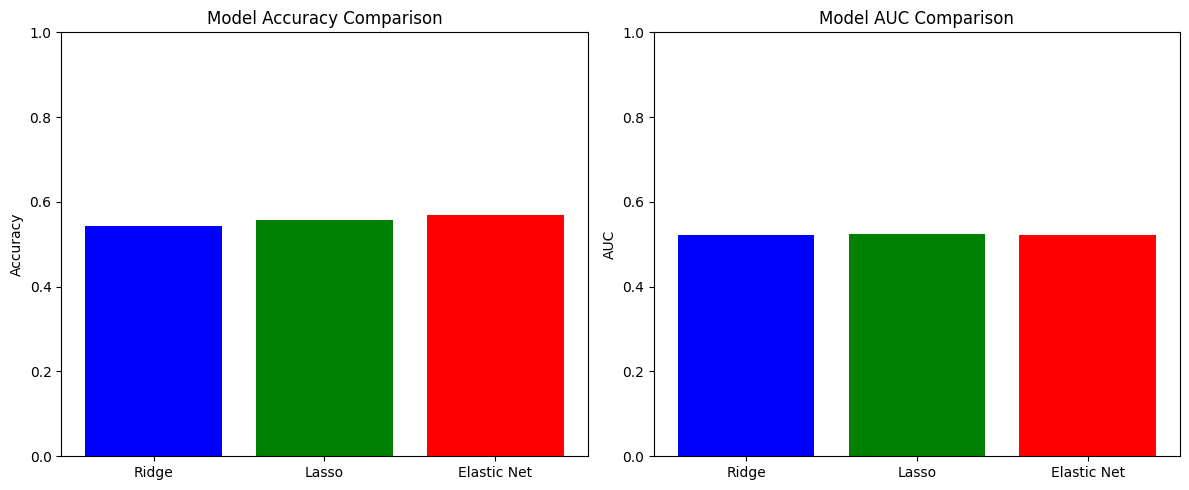

In [19]:
# Create a comparison table
models = ['Ridge', 'Lasso', 'Elastic Net']
accuracies = [ridge_accuracy, lasso_accuracy, elastic_accuracy]
auc_scores = [ridge_auc, lasso_auc, elastic_auc]

comparison_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracies,
    'AUC': auc_scores
})

print("=== Model Performance Comparison ===")
print(comparison_df.round(4))

# Plot comparison
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy comparison
ax[0].bar(models, accuracies, color=['blue', 'green', 'red'])
ax[0].set_title('Model Accuracy Comparison')
ax[0].set_ylabel('Accuracy')
ax[0].set_ylim(0, 1)

# AUC comparison
ax[1].bar(models, auc_scores, color=['blue', 'green', 'red'])
ax[1].set_title('Model AUC Comparison')
ax[1].set_ylabel('AUC')
ax[1].set_ylim(0, 1)

plt.tight_layout()
plt.show()

### ROC curves

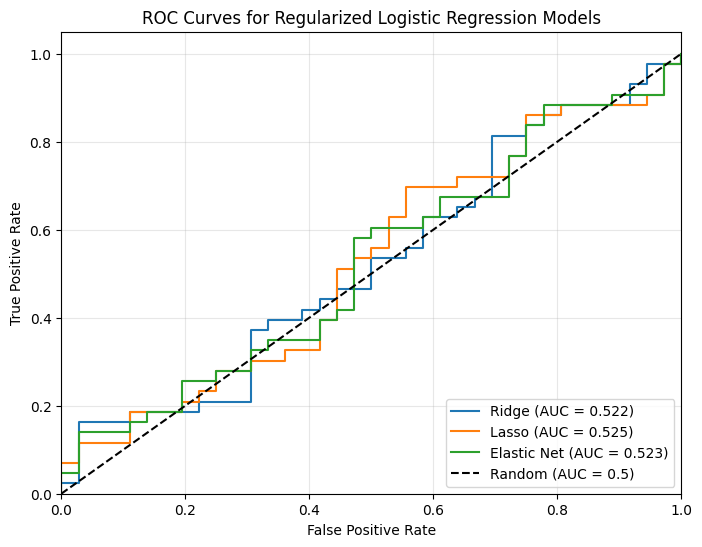

In [21]:
# Plot ROC curves for all models
plt.figure(figsize=(8, 6))

# Ridge ROC
fpr_ridge, tpr_ridge, _ = roc_curve(y_test, y_pred_proba_ridge)
roc_auc_ridge = auc(fpr_ridge, tpr_ridge)
plt.plot(fpr_ridge, tpr_ridge, label=f'Ridge (AUC = {roc_auc_ridge:.3f})')

# Lasso ROC
fpr_lasso, tpr_lasso, _ = roc_curve(y_test, y_pred_proba_lasso)
roc_auc_lasso = auc(fpr_lasso, tpr_lasso)
plt.plot(fpr_lasso, tpr_lasso, label=f'Lasso (AUC = {roc_auc_lasso:.3f})')

# Elastic Net ROC
fpr_elastic, tpr_elastic, _ = roc_curve(y_test, y_pred_proba_elastic)
roc_auc_elastic = auc(fpr_elastic, tpr_elastic)
plt.plot(fpr_elastic, tpr_elastic, label=f'Elastic Net (AUC = {roc_auc_elastic:.3f})')

# Diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Regularized Logistic Regression Models')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

In [22]:
def detailed_model_evaluation(y_true, y_pred, y_pred_proba, model_name):
    """Provide detailed evaluation of a model"""
    print(f"\n=== {model_name} Detailed Evaluation ===")
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)
    
    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    
    # Additional metrics
    accuracy = accuracy_score(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_pred_proba)
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC: {auc_score:.4f}")
    
    return cm, accuracy, auc_score

# Evaluate all models
ridge_cm, ridge_acc, ridge_auc = detailed_model_evaluation(
    y_test, y_pred_ridge, y_pred_proba_ridge, "Ridge"
)

lasso_cm, lasso_acc, lasso_auc = detailed_model_evaluation(
    y_test, y_pred_lasso, y_pred_proba_lasso, "Lasso"
)

elastic_cm, elastic_acc, elastic_auc = detailed_model_evaluation(
    y_test, y_pred_elastic, y_pred_proba_elastic, "Elastic Net"
)


=== Ridge Detailed Evaluation ===
Confusion Matrix:
[[ 0 36]
 [ 0 43]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        36
           1       0.54      1.00      0.70        43

    accuracy                           0.54        79
   macro avg       0.27      0.50      0.35        79
weighted avg       0.30      0.54      0.38        79

Accuracy: 0.5443
AUC: 0.5220

=== Lasso Detailed Evaluation ===
Confusion Matrix:
[[13 23]
 [12 31]]

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.36      0.43        36
           1       0.57      0.72      0.64        43

    accuracy                           0.56        79
   macro avg       0.55      0.54      0.53        79
weighted avg       0.55      0.56      0.54        79

Accuracy: 0.5570
AUC: 0.5252

=== Elastic Net Detailed Evaluation ===
Confusion Matrix:
[[ 9 27]
 [ 7 36]]

Classification Re

=== Coefficient Comparison Across Models ===
           Feature   Ridge   Lasso  Elastic Net
0              WAs -0.0036  0.0459       0.0000
1              WFe -0.0012  0.0000       0.0000
2            SAoFe -0.0005  0.0000       0.0000
3              SOC -0.0003 -0.0013       0.0000
4  Year_Irrigation  0.0031  0.0099       0.0000
5     Distance_STW  0.0125  0.2937       0.1621


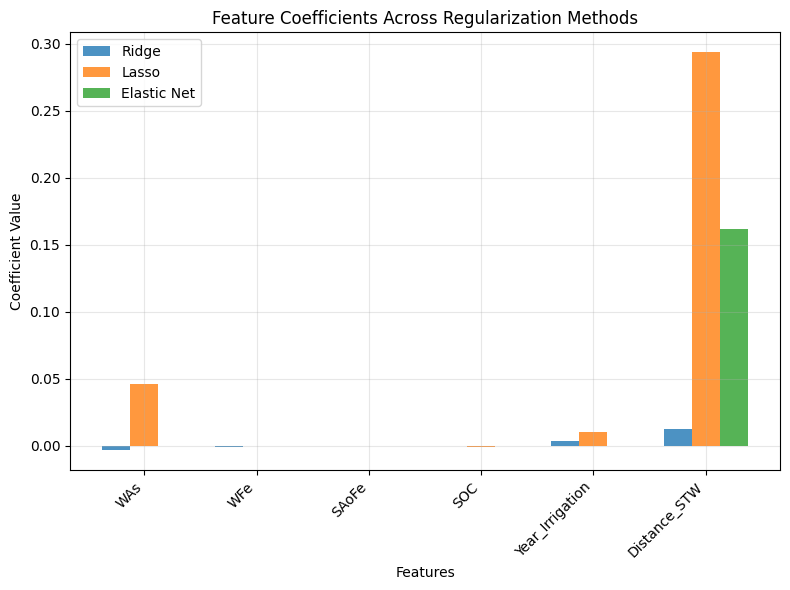


Features selected by Lasso (4):
           Feature   Lasso
0              WAs  0.0459
3              SOC -0.0013
4  Year_Irrigation  0.0099
5     Distance_STW  0.2937


In [24]:
# Create a DataFrame to compare coefficients across models
feature_names = X_train.columns

coef_comparison = pd.DataFrame({
    'Feature': feature_names,
    'Ridge': ridge_model.coef_[0],
    'Lasso': lasso_model.coef_[0],
    'Elastic Net': elastic_net_model.coef_[0]
})

print("=== Coefficient Comparison Across Models ===")
print(coef_comparison.round(4))

# Plot coefficients
fig, ax = plt.subplots(figsize=(8, 6))

x = np.arange(len(feature_names))
width = 0.25

ax.bar(x - width, coef_comparison['Ridge'], width, label='Ridge', alpha=0.8)
ax.bar(x, coef_comparison['Lasso'], width, label='Lasso', alpha=0.8)
ax.bar(x + width, coef_comparison['Elastic Net'], width, label='Elastic Net', alpha=0.8)

ax.set_xlabel('Features')
ax.set_ylabel('Coefficient Value')
ax.set_title('Feature Coefficients Across Regularization Methods')
ax.set_xticks(x)
ax.set_xticklabels(feature_names, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Highlight features selected by Lasso (non-zero coefficients)
lasso_selected = coef_comparison[coef_comparison['Lasso'] != 0]
print(f"\nFeatures selected by Lasso ({len(lasso_selected)}):")
print(lasso_selected[['Feature', 'Lasso']].round(4))

## Summary and Conclusion

In this tutorial, we've explored regularized logistic regression in Python, covering both implementation from scratch and using scikit-learn's efficient implementations. Here are the key takeaways:

1. **Regularization helps prevent overfitting**: By adding penalty terms to the loss function, we can control model complexity and improve generalization.

2. **Different regularization types serve different purposes**:
   - **Ridge (L2)**: Shrinks all coefficients but keeps all features. Good for handling multicollinearity.
   - **Lasso (L1)**: Performs feature selection by setting some coefficients to exactly zero.
   - **Elastic Net**: Combines L1 and L2 penalties, offering a balance between feature selection and coefficient shrinkage.

3. **Hyperparameter tuning is crucial**: The regularization strength (lambda or C in scikit-learn) and the L1/L2 balance (alpha in Elastic Net) should be tuned using cross-validation.

4. **scikit-learn provides efficient implementations**: While implementing from scratch helps understand the mathematics, scikit-learn's `LogisticRegression` with different penalty parameters is more efficient and robust for practical applications.

5. **Model evaluation is multi-faceted**: Use multiple metrics (accuracy, precision, recall, F1-score, AUC) and visualizations (ROC curves, coefficient plots) to comprehensively evaluate model performance.

## Resources

1. [Ridge and Lasso in R](https://www.datacareer.ch/blog/ridge-and-lasso-in-r/)
2. [Penalized Logistic Regression Essentials in R: Ridge, Lasso and Elastic Net](http://www.sthda.com/english/articles/36-classification-methods-essentials/149-penalized-logistic-regression-essentials-in-r-ridge-lasso-and-elastic-net/)
3. [Factors Affecting Paddy Soil Arsenic Concentration in Bangladesh](https://doi.org/10.1016/j.scitotenv.2011.10.008)